# AI Bubble Predictor

AI is a very trendy topic nowadays. Everyone is talking about it, and we hear about it everywhere. But can it really deliver on its promises?

I don't think so. I think that AI is just a bubble that will burst soon. It's a great technology, but it's not as powerful as people think. As any tool, it has its limitations — and those have been overlooked by many.

In this project, I will build a model to predict when the AI bubble will burst. I will use historical data about a phenomenon I believe was similar to the AI bubble (the dot-com bubble) to train an LSTM model. Then, I will use this model to generate a hypothesis about when the AI bubble will burst.

I hope this project will help people understand the limitations of AI and avoid the consequences of the burst of the AI bubble.

## Getting the data

In [1]:
# First, get stock market data about the dot-com bubble

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Get the stock data
full_timeframe_start = datetime.datetime(1990, 1, 1)
full_timeframe_end = datetime.datetime(2012, 1, 1)
companies = ['MSFT', 'AAPL', 'AMZN', 'INTL', 'ORCL', 'INTC', 'QCOM', 'HPQ', 'EBAY', 'VZ', 'T', 'GOOGL', 'FB', 'TWTR', 'SNAP', 'TSLA', 'NFLX', 'DIS', 'CMCSA', 'FOXA', 'DISCA', 'VIAC', 'NWSA', 'NWS', 'CBS']
stock_data = yf.download(tickers=companies, start=full_timeframe_start, end=full_timeframe_end)
# Remove those columns that have any NaN values
stock_data = stock_data.dropna(axis=1)
companies = stock_data.columns.get_level_values(1).unique()
num_companies = len(companies)
print(f"Number of companies: {num_companies}")

# Save the data to a CSV file
stock_data.to_csv('stock_data.csv')

display(stock_data.head())

[*********************100%%**********************]  25 of 25 completed

10 Failed downloads:
['TWTR', 'DISCA', 'FB', 'VIAC', 'CBS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['INTL', 'NWSA', 'NWS', 'FOXA', 'SNAP']: YFChartError("%ticker%: Data doesn't exist for startDate = 631170000, endDate = 1325394000")


Number of companies: 9


Price      Adj Close                                                    \
Ticker          AAPL     CMCSA       DIS       HPQ      INTC      MSFT   
Date                                                                     
1990-01-02  0.262721  1.311940  6.913749  1.186972  0.631242  0.380703   
1990-01-03  0.264485  1.321378  6.928716  1.165938  0.613707  0.382849   
1990-01-04  0.265367  1.293063  6.921232  1.153917  0.626858  0.394109   
1990-01-05  0.266249  1.264748  6.943679  1.138893  0.622474  0.384457   
1990-01-08  0.268012  1.274186  7.003305  1.159927  0.631242  0.390355   

Price                                        Close  ...       Open     Volume  \
Ticker          ORCL         T        VZ      AAPL  ...         VZ       AAPL   
Date                                                ...                         
1990-01-02  0.483362  1.427554  5.244071  0.332589  ...  25.124830  183198400   
1990-01-03  0.430768  1.402751  5.232572  0.334821  ...  25.630699  207995200   
1990-01-04  0.443290  1.391254  5.080447  0.335938  ...  25.293453  221513600   
1990-01-05  0.418246  1.324207  4.964325  0.337054  ...  24.478441  123312000   
1990-01-08  0.433273  1.346555  5.004965  0.339286  ...  23.832052  101572800   

Price                                                                   \
Ticker        CMCSA      DIS       HPQ      INTC       MSFT       ORCL   
Date                                                                     
1990-01-02  2633400  6983477  11561381  63833600   53035200   35510400   
1990-01-03  2278800  8077040  12022920  69504000  113774400  179844300   
1990-01-04  3684600  7721845   6810346  58483200  125740800  125278650   
1990-01-05   976500  3961885   5281277  37036800   69566400   51017850   
1990-01-08  2363400  6647745   5903122  43305600   58982400   33161400   

Price                         
Ticker            T       VZ  
Date                          
1990-01-02  3622994  1304092  
1990-01-03  3306822  1014986  
1990-01-04  3264454  1331669  
1990-01-05  3073269  1611435  
1990-01-08  2713670  1051458  

[5 rows x 54 columns]

## Training the LSTM model

In [2]:
# Here, we'll transform the data to make it easier to work with. We'll calculate the daily returns for each stock.
# We'll also calculate the average daily return for the dot-com bubble period.
# Finally, we'll calculate the average daily return for the period after the dot-com bubble.

# Calculate the daily returns
stock_data['Adj Close'].pct_change()
print(f'Stock data shape: {stock_data.shape}')

# Calculate the average daily return for the dot-com bubble period
dot_com_bubble_start = full_timeframe_start
dot_com_bubble_end = datetime.datetime(2002, 1, 1)

dot_com_bubble_returns = stock_data.loc[dot_com_bubble_start:dot_com_bubble_end]['Adj Close'].pct_change().mean()

# Calculate the average daily return for the period after the dot-com bubble
post_dot_com_bubble_start = dot_com_bubble_end
post_dot_com_bubble_end = full_timeframe_end

post_dot_com_bubble_returns = stock_data.loc[post_dot_com_bubble_start:post_dot_com_bubble_end]['Adj Close'].pct_change().mean()

print('Average daily return for the dot-com bubble period:', dot_com_bubble_returns)
print('Average daily return for the period after the dot-com bubble:', post_dot_com_bubble_returns)

Stock data shape: (5547, 54)
Average daily return for the dot-com bubble period: Ticker
AAPL     0.000709
CMCSA    0.000986
DIS      0.000480
HPQ      0.000884
INTC     0.001502
MSFT     0.001597
ORCL     0.001812
T        0.000622
VZ       0.000474
dtype: float64
Average daily return for the period after the dot-com bubble: Ticker
AAPL     0.001723
CMCSA    0.000299
DIS      0.000478
HPQ      0.000366
INTC     0.000227
MSFT     0.000173
ORCL     0.000522
T        0.000308
VZ       0.000296
dtype: float64


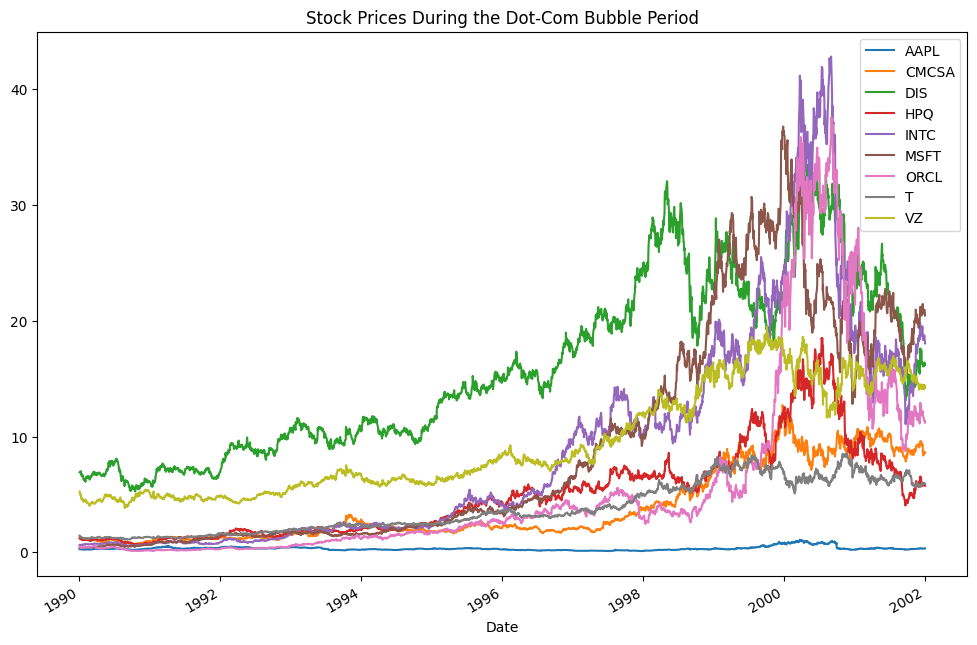

In [3]:
# Now, let's plot the stock prices for each company during the dot-com bubble period.
# We'll also plot the average daily return for the dot-com bubble period and the period after the dot-com bubble.

# Plot the stock prices for each company during the dot-com bubble period
stock_data.loc[dot_com_bubble_start:dot_com_bubble_end]['Adj Close'].plot(figsize=(12, 8))
plt.title('Stock Prices During the Dot-Com Bubble Period')
plt.legend(companies)
plt.show()

In [4]:
# Now, use the transformed data to train an LSTM model to predict the stock prices for the next day.

# First, we'll normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data["Adj Close"])
print(f"Scaled data shape: {scaled_data.shape}")

import torch


# Now, we'll create the input and output sequences for the LSTM model
def create_sequences(data, number_past, number_future):
    X, y = [], []
    seq_length_max = number_past + number_future
    for i in range(len(data) - seq_length_max):
        # Generate sequences of length seq_length_max like: [0, 1, 2, ..., seq_length_max-1], [1, 2, 3, ..., seq_length_max], ...
        X.append(data[i : i + number_past])
        # y.append(data[i+1:i + seq_length_max + 1])
        y.append(data[i + number_past : i + number_past + number_future])
    return torch.FloatTensor(X), torch.FloatTensor(
        y
    )  # Convert the data to PyTorch tensors


seq_length_max = 360 * 2  # i.e. the model will look at the previous 60 days to predict the stock price for the next day
seq_length_past = seq_length_max // 2
seq_length_future = seq_length_max // 2
seq_length_test_prompt = seq_length_past


X, y = create_sequences(scaled_data, seq_length_past, seq_length_future)

# We need to create the sequences before splitting the data into training and testing sets, as the sequences need to be continuous
# If we split the data first, the sequences would be broken up and the model wouldn't be able to learn from them
# Now, we'll split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)  # This keeps the sequences continuous

print(f"Type of X_train: {type(X_train)}")
print(f"Type of y_train: {type(y_train)}")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Scaled data shape: (5547, 9)


/var/folders/g5/qwphv0rn5tvflncj75xsxvxw0000gn/T/ipykernel_1131/3800000122.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.FloatTensor(X), torch.FloatTensor(


Type of X_train: <class 'torch.Tensor'>
Type of y_train: <class 'torch.Tensor'>
X_train shape: torch.Size([3861, 360, 9])
y_train shape: torch.Size([3861, 360, 9])
X_test shape: torch.Size([966, 360, 9])
y_test shape: torch.Size([966, 360, 9])


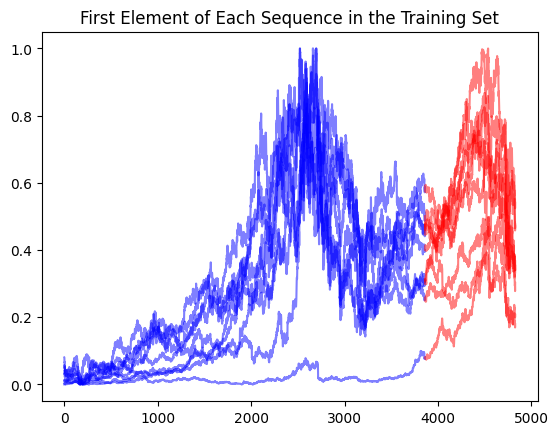

In [5]:
# Plot the first element of each sequence in the training set in blue, then plot the first element of each sequence in the testing set in red
# This verifies that the sequences are continuous in a visual way
plt.plot(range(len(X_train)), X_train[:, 0], label='Training set', color='blue', alpha=0.5)
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test[:, 0], label='Testing set', color='red', alpha=0.5)
plt.title('First Element of Each Sequence in the Training Set')
plt.show()

In [6]:
# Now, we'll build the LSTM model with PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable

# Ensure reproducibility
import random

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


class LSTM(nn.Module):

    def __init__(
        self,
        input_size=1,
        hidden_layer_size=100,
        output_size=1,
        num_layers=1,
        dropout=0.0,
        device="cpu",
    ):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.input_size = input_size

        # Apply dropout to the input layer
        self.dropout = nn.Dropout(dropout).to(device)

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_layer_size,
            num_layers=num_layers,
            dropout=(
                dropout if num_layers > 1 else 0
            ),  # It doesn't make sense to apply dropout if we only have 1 layer
            batch_first=True,
        ).to(
            device
        )  # Input_size is 1 because we're using the daily returns as input (this is just 1 dimension)

        self.linear = nn.Linear(hidden_layer_size, output_size).to(device)

        self.device = device

    def forward(self, input_seq: Variable) -> Variable:
        # print(f"input_seq shape: {input_seq.shape}")
        batch_size = input_seq.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(
            self.device
        ).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(
            self.device
        ).requires_grad_()

        # Apply dropout to the input layer
        input_seq = self.dropout(input_seq)

        # We need to detach the hidden state to prevent the model from backpropagating through the entire history
        # lstm_out, (hn, cn) = self.lstm(input_seq, (h0.detach(), c0.detach()))
        lstm_out, (hn, cn) = self.lstm(input_seq, (h0, c0))
        # print(f'lstm_out shape: {lstm_out.shape}')
        print(f'lstm out shape: {lstm_out.shape}')
        print(f'hn shape: {hn.shape}')

        # Apply dropout to the output of the LSTM layer
        lstm_out = self.dropout(
            lstm_out
        )

        predictions = self.linear(lstm_out)
        # print(f"predictions shape: {predictions.shape}")
        return predictions

    def generate_predictions(
        self, input_seq: Variable, num_predictions_to_generate: int
    ) -> Variable:
        generated_items = starting_sequence
        current_window = starting_sequence

        # Prepare the initial hidden state
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(
            self.device
        )
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(
            self.device
        )
        for num_item in range(num_predictions_to_generate):
            lstm_output, (hn, cn) = self.lstm(
                current_window, (h0.detach(), c0.detach())
            )
            h0, c0 = hn, cn
            output = self.linear(lstm_output)
            items_to_add_to_window = output[:, -1, :].view(
                -1, 1, starting_sequence.shape[-1]
            )
            current_window = torch.roll(current_window, -1, 1)
            # We can't just concatenate the items because the shapes don't match
            # We need to remove the last item from the current window and add the new item
            current_window[:, -1, :] = items_to_add_to_window.view(
                starting_sequence.shape[0], starting_sequence.shape[-1]
            )
            generated_items = torch.cat(
                [generated_items, items_to_add_to_window], dim=1
            )

        return generated_items.view(
            starting_sequence.shape[0], -1, starting_sequence.shape[-1]
        )

    def forward2(self, input_seq: Variable) -> Variable:
        # print(f"input_seq shape: {input_seq.shape}")
        lstm_out, _ = self.lstm(input_seq)
        # print(f'lstm_out shape: {lstm_out.shape}')
        predictions = self.linear(lstm_out)
        # print(f"predictions shape: {predictions.shape}")
        return predictions

In [7]:
# If cuda is available, move the model to the GPU
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
# Is mps available?
elif torch.backends.mps.is_built():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

# device = torch.device('cpu')

# Only take the first company for now
# X_train = X_train[:, :, 1:2]
# y_train = y_train[:, :, 1:2]
# X_test = X_test[:, :, 1:2]
# y_test = y_test[:, :, 1:2]

# Also move the training data to the GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
print(f"Shape of X_train: {X_train.shape}")
print(f"Device of X_train: {X_train.device}")
print(f"Type of X_train: {type(X_train)}")

num_layers = 1
hidden_layer_size = 16

Using MPS
Shape of X_train: torch.Size([3861, 360, 9])
Device of X_train: mps:0
Type of X_train: <class 'torch.Tensor'>


LSTM(
  (dropout): Dropout(p=0.0, inplace=False)
  (lstm): LSTM(1, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

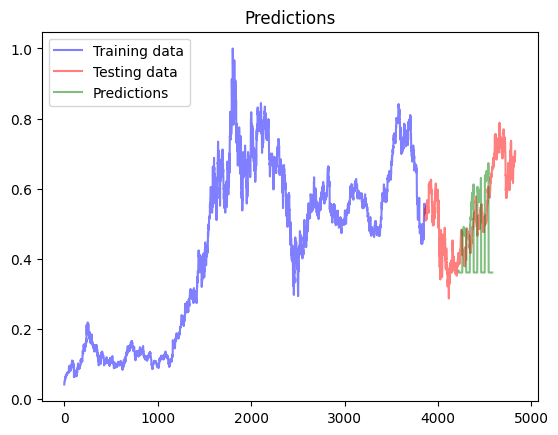

  1%|          | 1/100 [00:05<08:55,  5.41s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

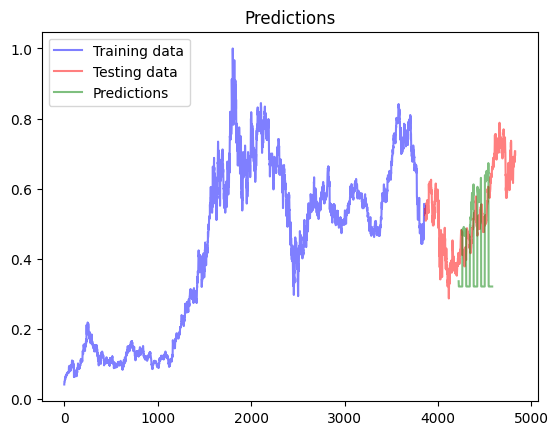

  2%|▏         | 2/100 [00:09<07:39,  4.69s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

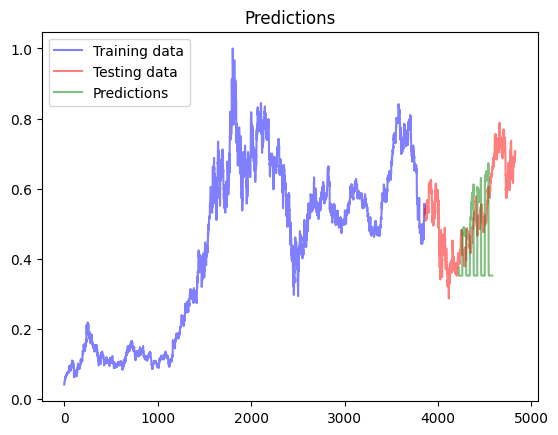

  3%|▎         | 3/100 [00:13<07:10,  4.44s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

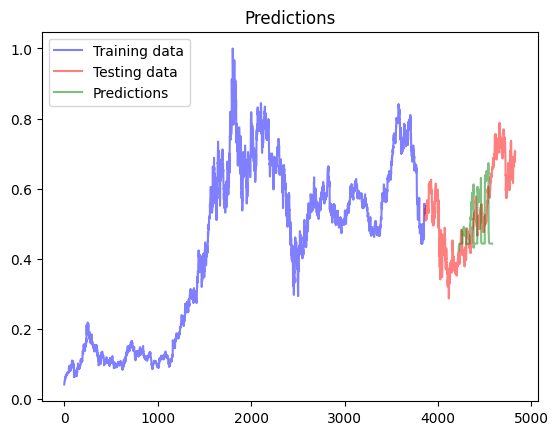

  4%|▍         | 4/100 [00:17<06:52,  4.30s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

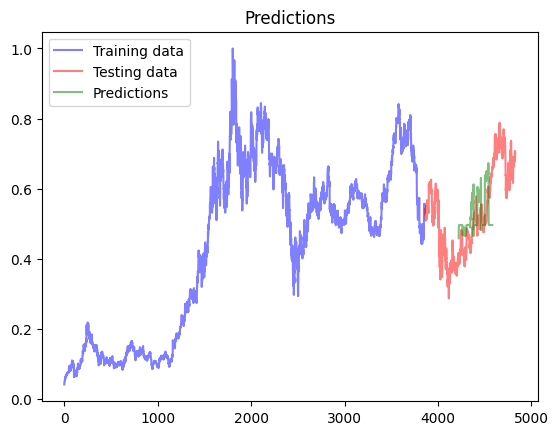

  5%|▌         | 5/100 [00:21<06:37,  4.18s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

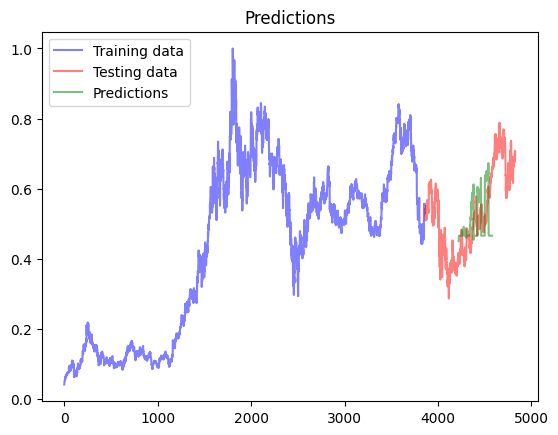

  6%|▌         | 6/100 [00:25<06:26,  4.11s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

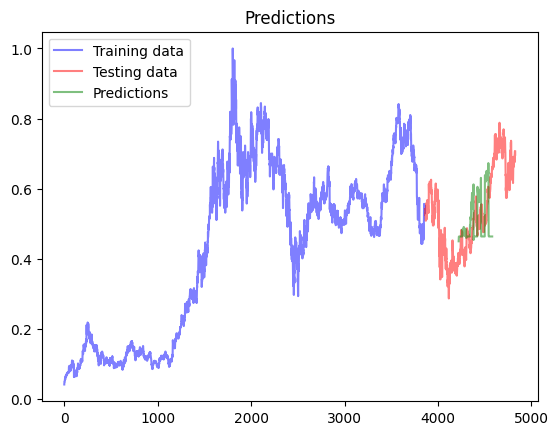

  7%|▋         | 7/100 [00:29<06:24,  4.14s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

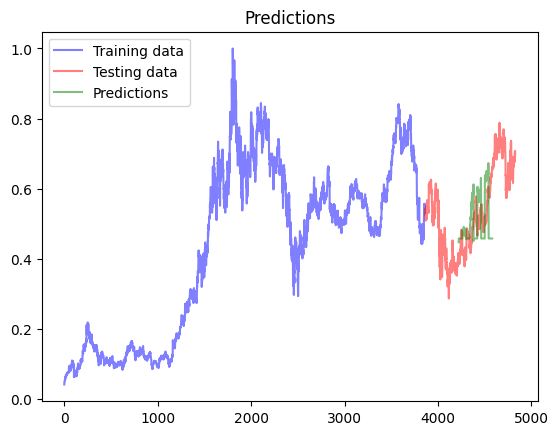

  8%|▊         | 8/100 [00:33<06:17,  4.10s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

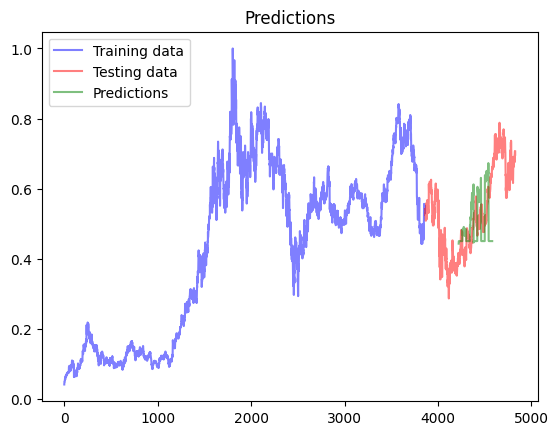

  9%|▉         | 9/100 [00:38<06:15,  4.12s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

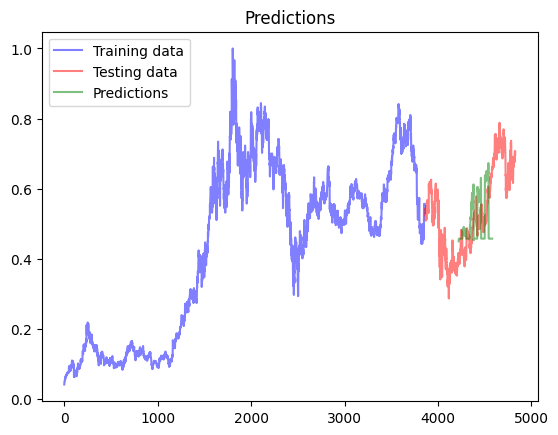

 10%|█         | 10/100 [00:42<06:13,  4.14s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

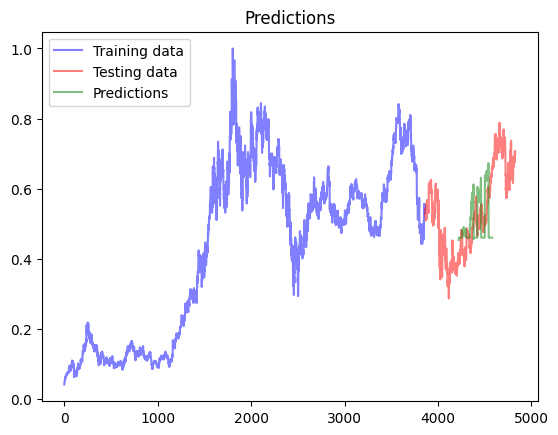

 11%|█         | 11/100 [00:46<06:06,  4.12s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

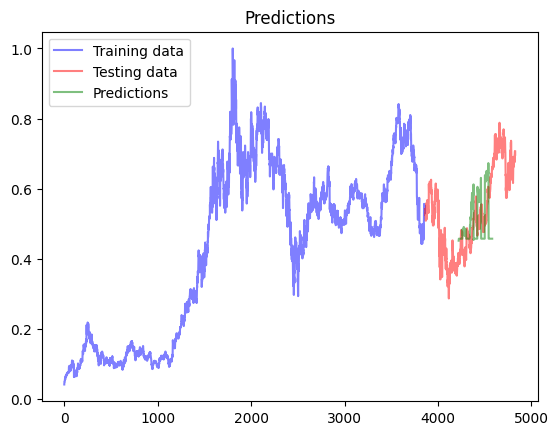

 12%|█▏        | 12/100 [00:50<06:03,  4.13s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

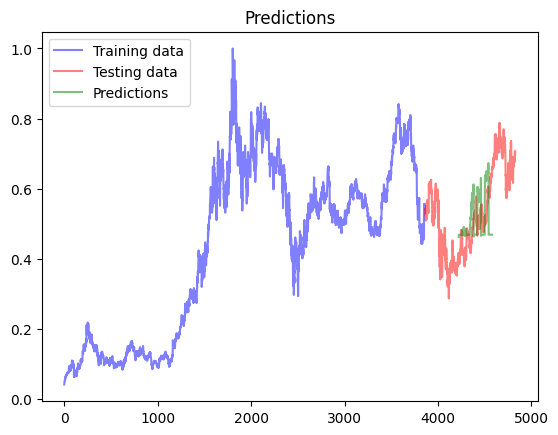

 13%|█▎        | 13/100 [00:54<06:01,  4.15s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

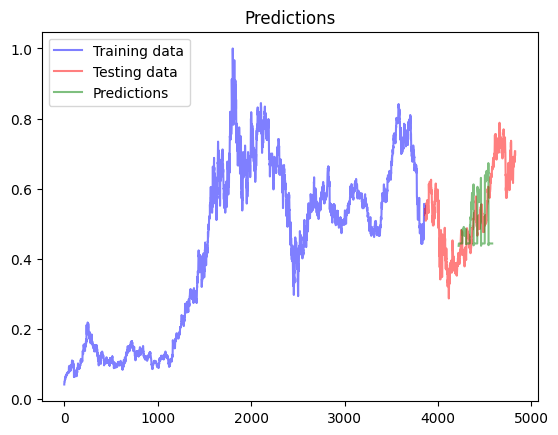

 14%|█▍        | 14/100 [00:58<05:57,  4.16s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

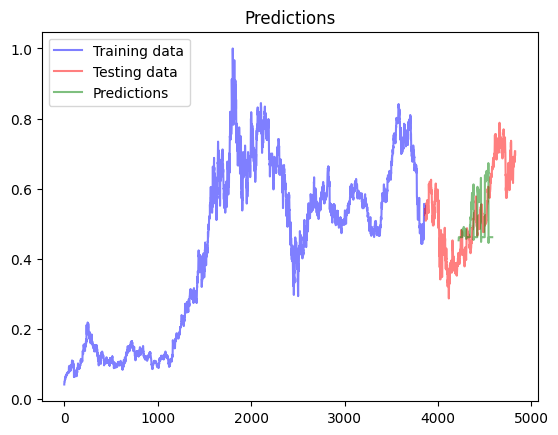

 15%|█▌        | 15/100 [01:02<05:49,  4.11s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

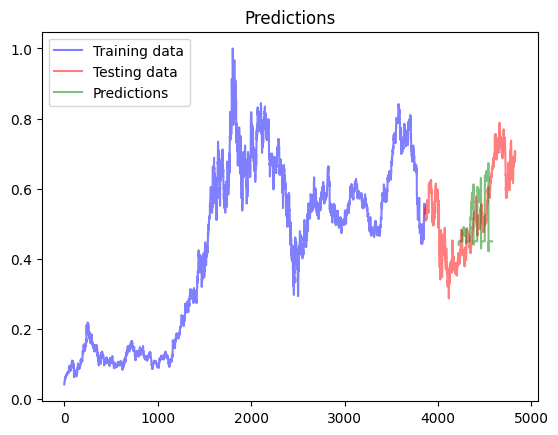

 16%|█▌        | 16/100 [01:07<05:44,  4.10s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

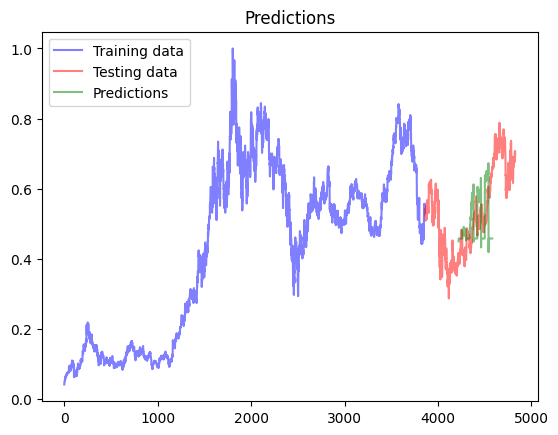

 17%|█▋        | 17/100 [01:11<05:38,  4.08s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

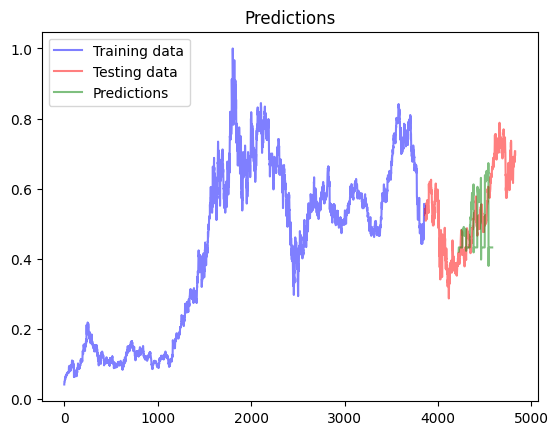

 18%|█▊        | 18/100 [01:15<05:33,  4.07s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

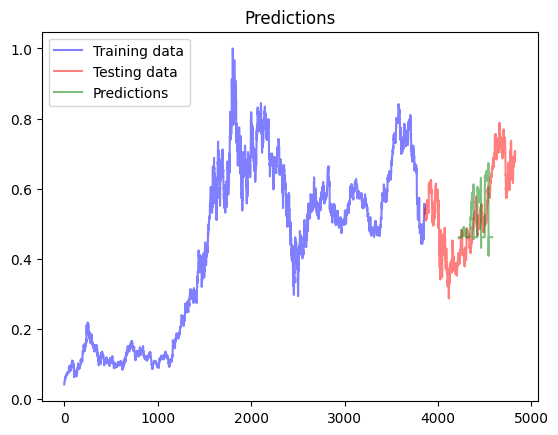

 19%|█▉        | 19/100 [01:19<05:28,  4.06s/it]

lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 16])
hn shape: torch.Size([1, 1152, 16])
lstm out shape: torch.Size([1152, 360, 1

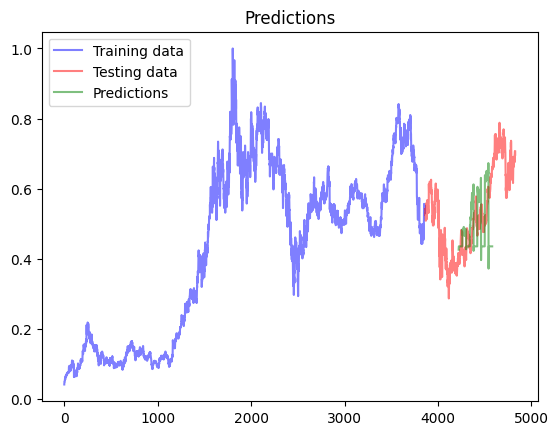

 19%|█▉        | 19/100 [01:23<05:55,  4.39s/it]

Early stopping
Best epoch: 4
Model saved


In [8]:
model = LSTM(
    input_size=1,
    hidden_layer_size=hidden_layer_size,
    output_size=1,
    num_layers=num_layers,
    device=device,
    # dropout=0.15,
)
print(model)

loss_function = nn.MSELoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
loader = torch.utils.data.DataLoader(tensor_dataset, batch_size=128, shuffle=True)

# Train the model
epochs = 100
log_every = 1
import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

INDEX_OF_COMPANY_TO_PLOT = 1


# Monitor the training and testing RMSE and stop training when the testing RMSE starts to increase, as this is a sign of overfitting
best_test_rmse = float("inf")
best_model = None
best_epoch = 0
patience = 15

remaining_patience = patience
for epoch in tqdm.tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X_batch, y_batch in loader:
        # X_batch has shape (batch_size, seq_length_max, num_companies). Turn it into (batch_size, seq_length_max, input_size)
        X_batch_all_companies_together = X_batch.view(-1, seq_length_past, 1)
        # y_batch has shape (batch_size). Turn it into (batch_size, output_size)

        y_pred = model(X_batch_all_companies_together)
        y_pred = y_pred.view(-1, seq_length_future, y_batch.shape[-1])
        loss = loss_function(y_pred, y_batch)
        writer.add_scalar("loss", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Monitor the training and testing RMSE
    model.eval()
    with torch.no_grad():
        num_of_companies_in_batch = X_batch.shape[-1]

        y_test_without_prompt = y_test[0, :, :].view(1, -1, num_of_companies_in_batch)
        # Only take the first seq_length_test_prompt days of the testing data to start the predictions, then evaluate on the rest up to seq_length_max
        starting_sequence = X_test[0, :, :].view(
            num_of_companies_in_batch,
            -1,
            1,  # We need to turn the companies into the batch dimension, because the model expects the batch dimension to be first and the last dimension to be the input size (1)
        )  # First sequence of the first company
        y_pred = model.generate_predictions(
            starting_sequence, num_predictions_to_generate=seq_length_future
        )
        y_pred = y_pred.view(
            1, -1, num_of_companies_in_batch
        )  # Turn the companies back into the last dimension
        y_pred = y_pred[
            :, seq_length_future:, :
        ]  # Only take the predictions after the prompt
        test_rmse = torch.sqrt(loss_function(y_pred, y_test_without_prompt)).item()
    writer.add_scalar("test_rmse", test_rmse, epoch)
    # Also check for exploding gradients
    for name, param in model.named_parameters():
        if param.grad is not None:
            writer.add_histogram(name, param.grad, epoch)
    print(
        f"Epoch {epoch}: test RMSE {test_rmse:.4f}, average loss {total_loss / len(loader):.4f}"
    )
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        best_model = model.state_dict()
        best_epoch = epoch
        print(f"====> New best!")

    if epoch % log_every == 0:
        # Get the full training and testing data for one of the companies (the first one)
        y_train_full = y_train[:, -1, INDEX_OF_COMPANY_TO_PLOT]
        y_train_full = y_train_full.view(-1, 1)

        # Plot the predictions for the training and testing data. The training data is in blue, the testing data is in red (one goes after the other)
        plt.plot(
            range(len(y_train_full)),
            y_train_full.cpu(),
            label="Training data",
            color="blue",
            alpha=0.5,
        )
        plt.plot(
            range(
                len(y_train_full),
                len(y_train_full) + len(y_test[:, -1, INDEX_OF_COMPANY_TO_PLOT]),
            ),
            y_test[:, -1, INDEX_OF_COMPANY_TO_PLOT].cpu(),
            label="Testing data",
            color="red",
            alpha=0.5,
        )
        plt.plot(
            range(
                len(y_train_full) + seq_length_test_prompt,
                len(y_train_full) + seq_length_max,
            ),
            y_pred[:, :, INDEX_OF_COMPANY_TO_PLOT].squeeze().cpu(),
            label="Predictions",
            color="green",
            alpha=0.5,
        )
        plt.title("Predictions")
        plt.legend()
        plt.show()

    if test_rmse > best_test_rmse:
        remaining_patience -= 1
        if remaining_patience == 0:
            print("Early stopping")
            break
    else:
        remaining_patience = patience

# Load the best model
model.load_state_dict(best_model)
print(f"Best epoch: {best_epoch}")

writer.close()

# Store the model
torch.save(model.state_dict(), "lstm_model.pt")
print("Model saved")

In [9]:
# Load the model from the file
model = LSTM(
    input_size=1,
    hidden_layer_size=hidden_layer_size,
    output_size=1,
    num_layers=num_layers,
    device=device,
)
model.load_state_dict(torch.load("lstm_model.pt"))

# Evaluate the model
model.eval()

# Make predictions. We'll get num_companies predictions for each test sequence.
print(f"X_test shape: {X_test.shape}")
# X_test: (num_sequences, seq_length_max, num_companies)
with torch.no_grad():
    y_pred = model(X_test.view(-1, seq_length_max, 1))
    print(f"y_pred shape: {y_pred.shape}")

# Calculate the loss
all_predictions = y_pred
print("Loss:", loss.item())
# Calculate the average difference between the predicted and actual stock prices
average_diff = torch.mean(torch.abs(all_predictions[seq_length_max:, ...] - y_test[seq_length_max:, ...]))
print("Average difference:", average_diff.item())

# Finally, we'll plot the predicted stock prices for the next day.
# We'll also plot the actual stock prices for the test data.

# Choose a color map so that each company has a different color and the colors are the same for the predicted and actual stock prices
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(num_companies)] # These are rbga colors

# Plot the percentage change in stock prices for each company
# Use the colors defined above to plot the predicted and actual stock prices for each company
for i in range(1):
    plt.figure(figsize=(12, 8))
    plt.plot(all_predictions[:, i].cpu().numpy(), label=f"{companies[i]} (pred)", linestyle="--", color=colors[i])
    plt.plot(y_test[:, i].cpu().numpy(), label=f"{companies[i]} (actual)", color=colors[i])
    # y range: -1 to 1
    plt.ylim(-1, 1)
    plt.xlabel("Day")
    plt.ylabel("Stock Price")
    plt.title("Predicted vs. Actual Stock Prices")
    plt.legend()
    plt.show()

X_test shape: torch.Size([966, 360, 9])
lstm out shape: torch.Size([4347, 720, 16])
hn shape: torch.Size([1, 4347, 16])
y_pred shape: torch.Size([4347, 720, 1])


/var/folders/g5/qwphv0rn5tvflncj75xsxvxw0000gn/T/ipykernel_1131/3082802176.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lstm_model.p

Loss: 0.021398993209004402


RuntimeError: The size of tensor a (720) must match the size of tensor b (360) at non-singleton dimension 1

In [ ]:
# Inverse transform the data
y_test_pred = scaler.inverse_transform(all_predictions.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

# Plot the predicted stock prices for the next day
for i in range(5):
    plt.figure(figsize=(12, 8))
    plt.plot(y_test_pred[:, i], label=f"{companies[i]} (pred)", linestyle="--", color=colors[i])
    plt.plot(y_test_actual[:, i], label=f"{companies[i]} (actual)", color=colors[i])
    plt.xlabel("Day")
    plt.ylabel("Stock Price")
    plt.title("Predicted vs. Actual Stock Prices")
    plt.legend()
    plt.show()

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
starting_sequence = X_test[0, ...].unsqueeze(dim=0) # First sequence of the first company
num_to_generate = X_test.shape[0] - seq_length_max # We want to generate the rest of the test data, i.e. what's remaining after this first sequence
with torch.no_grad():
    generations = model.generate_predictions(starting_sequence, num_to_generate)
display(generations)

# Plot the percentage change in stock prices for each company
for i in range(1):
    plt.figure(figsize=(12, 8))
    plt.plot(y_test[:, i].cpu().numpy(), label=f"{companies[i]} (actual)", color=colors[i])
    # Draw a vertical line after the ending of the prompt (seq_length_max)
    plt.axvline(x=seq_length_max, color='black', linestyle='--')
    plt.plot(range(seq_length_max, seq_length_max + num_to_generate), generations[0, seq_length_max:, i].cpu().numpy(), label=f"{companies[i]} (pred)", linestyle="--", color=colors[i])
    plt.ylim(-1, 1)
    plt.xlabel("Day")
    plt.ylabel("Stock Price")
    plt.title("Predicted vs. Actual Stock Prices")
    plt.legend()
    plt.show()